### Configuration

In [1]:
import os
import ipympl
import numpy as np
import pandas as pd
from scipy import stats

import mne
import yasa
from yasa import sw_detect
from yasa import spindles_detect
from scipy.stats import median_abs_deviation
import plotnine as pn

from utils__helpers_macro import robust_zscore
import utils__config

In [2]:
os.chdir(utils__config.working_directory)
os.getcwd()

'g:\\My Drive\\Residency\\Research\\Lab - Damisah\\Project - Sleep'

### Parameters

In [3]:
fif_path = 'Cache/Subject01/S01_Feb02_256hz.fif'
potato_path = 'Cache/Subject01/S01_potatogram.csv'
dictionary_path = 'Data/Subject01/S01_dictionary.xlsx'
legui_path = 'Cache/Subject01/S01_electrodes.csv'
bad_channel_path = 'Cache/Subject01/S01_bad_channels.csv'
sw_path = 'Cache/Subject01/S01_SW_raw.csv'
kc_path = 'Cache/Subject01/S01_KC_raw.csv'
sp_path = 'Cache/Subject01/S01_SP_raw.csv'
event_path = 'Cache/Subject01/S01_events_summary.csv'

# fif_path = 'Cache/Subject02/Apr26/S02_Apr26_256hz.fif'
# potato_path = 'Cache/Subject02/Apr26/S02_potatogram.csv'
# dictionary_path = 'Data/Subject02/S02_dictionary.xlsx'
# legui_path = 'Cache/Subject02/Apr26/S02_electrodes.csv'
# bad_channel_path = 'Cache/Subject02/Apr26/S02_bad_channels.csv'
# sw_path = 'Cache/Subject02/Apr26/S02_SW_raw.csv'
# kc_path = 'Cache/Subject02/Apr26/S02_KC_raw.csv'
# sp_path = 'Cache/Subject02/Apr26/S02_SP_raw.csv'
# event_path = 'Cache/Subject02/Apr26/S02_events_summary.csv'

# fif_path = 'Cache/Subject02/Apr27/S02_Apr27_256hz.fif'
# potato_path = 'Cache/Subject02/Apr27/S02_potatogram.csv'
# dictionary_path = 'Data/Subject02/S02_dictionary.xlsx'
# legui_path = 'Cache/Subject02/Apr27/S02_electrodes.csv'
# bad_channel_path = 'Cache/Subject02/Apr27/S02_bad_channels.csv'
# sw_path = 'Cache/Subject02/Apr27/S02_SW_raw.csv'
# kc_path = 'Cache/Subject02/Apr27/S02_KC_raw.csv'
# sp_path = 'Cache/Subject02/Apr27/S02_SP_raw.csv'
# event_path = 'Cache/Subject02/Apr27/S02_events_summary.csv'

In [5]:
sampling_freq = 256

### Load Data

In [6]:
raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = False)
print('Original channel count:', len(raw.ch_names))

# Select only macroelectrodes
raw.pick_types(seeg = True, ecog = True)

# Remove rejected channels
bad_channels = pd.read_csv(bad_channel_path)
bad_channels = bad_channels[bad_channels['channel'].isin(raw.ch_names)]
raw.drop_channels(ch_names = bad_channels['channel'].astype('string'))

print('Channel count after Channel Rejection:', len(raw.ch_names))

# Convert V to uV for YASA
data = raw.get_data() * 1e6

# Load hypnogram
hypnogram = np.loadtxt(potato_path, delimiter = ',')

C:\Users\Layton\AppData\Local\Temp\ipykernel_9364\1006497425.py:1: RuntimeWarning: This filename (Cache/Subject01/S01_Feb02_256hz.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz


Original channel count: 86
Channel count after Channel Rejection: 68


### Normalize with Robust Z-Score

Plot statistics of amplitudes and robust z-scores by channel

In [7]:
pn_data = pd.DataFrame(data.transpose())
pn_data.columns = raw.ch_names
pn_data = pn_data.reset_index()

pn_data = pn_data.melt(id_vars = ['index'], var_name = 'channel', value_name = 'amplitude')
pn_data.columns = ['sample', 'channel', 'amplitude']

#pn_data['rzscore'] = pn_data.groupby(['channel'])['amplitude'].transform(robust_zscore)

pn_data = pn_data.groupby(['channel']).agg({'amplitude' : [np.mean,
                                                           np.median,
                                                           lambda x: np.mean(np.abs(x)), 
                                                           lambda x: np.median(np.abs(x)),
                                                           np.std, 
                                                           median_abs_deviation, 
                                                           lambda x: x.quantile(0.10),
                                                           lambda x: x.quantile(0.25),
                                                           lambda x: x.quantile(0.75),
                                                           lambda x: x.quantile(0.90)]})
pn_data = pn_data.reset_index()

pn_data = pn_data.melt(id_vars = ['channel'], var_name = ['dummy', 'stat'], value_name = 'value')
pn_data.drop(columns = ['dummy'], inplace = True)
pn_data = pn_data.replace({'stat' : {'<lambda_0>' : 'abs_mean',
                                     '<lambda_1>' : 'abs_median',
                                     'std' : 'sd',
                                     'median_abs_deviation' : 'mad',
                                     '<lambda_2>' : 'q10', 
                                     '<lambda_3>' : 'q25', 
                                     '<lambda_4>' : 'q75', 
                                     '<lambda_5>' : 'q90'}})

amp_data = pn_data.copy(deep = True)
amp_data['stat'] = amp_data['stat'].astype('category')
amp_data['stat'] = amp_data['stat'].cat.reorder_categories(['q90', 'q75', 'q25', 'q10', 'mad', 'abs_median', 'median', 'sd', 'abs_mean', 'mean'])
amp_data.groupby(['stat']).describe().reset_index()

stat value                                                          \
              count       mean        std         min        25%        50%   
0         q90  68.0  56.286255  25.277906   26.462236  38.486451  49.133788   
1         q75  68.0  23.856442   9.403319   11.507912  17.090292  21.813332   
2         q25  68.0 -24.380763  10.064224  -52.307770 -28.383013 -22.215586   
3         q10  68.0 -56.113850  25.243337 -127.706806 -65.857826 -49.793141   
4         mad  68.0  24.117291   9.715148   11.399942  17.221385  22.057609   
5  abs_median  68.0  24.130226   9.723698   11.401050  17.225679  22.058667   
6      median  68.0  -0.272859   0.769341   -3.064353  -0.701646  -0.126197   
7          sd  68.0  60.149696  23.350095   32.417427  42.841457  51.018355   
8    abs_mean  68.0  38.339900  16.060282   19.832310  26.329903  33.496546   
9        mean  68.0   0.034652   0.361628   -1.075518  -0.124823   0.052539   

                          
         75%         max  
0  65.646833  128.113695  
1  28.491909   48.960788  
2 -17.091375  -10.190964  
3 -37.911974  -24.600849  
4  28.457878   50.636396  
5  28.470911   50.687388  
6   0.164830    1.284555  
7  71.302860  130.697537  
8  44.174471   84.755657  
9   0.223206    1.268537

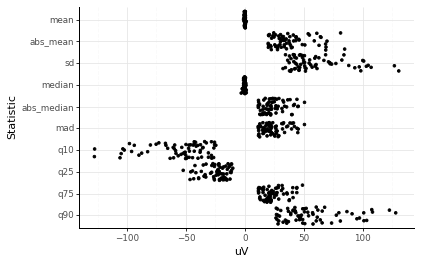

<ggplot: (144234221171)>

In [8]:
(pn.ggplot(amp_data)
 + pn.aes(x = 'stat', y = 'value')
 + pn.geom_jitter(size = 1)
 + pn.labs(x = 'Statistic', y = 'uV')
 + pn.theme_classic()
 + pn.theme(figure_size = (8, 3),
            panel_grid_major = pn.element_line(linetype = 'solid'),
            panel_grid_minor = pn.element_line(linetype = 'dashed'))
 + pn.coord_flip()
)

In [9]:
ex_uV = 100

ex_data = amp_data.groupby(['stat']).describe().reset_index()
ex_median = ex_data[ex_data.stat == 'median']['value']['mean'].item()
ex_mad = ex_data[ex_data.stat == 'mad']['value']['mean'].item()
ex_mean = ex_data[ex_data.stat == 'mean']['value']['mean'].item()
ex_sd = ex_data[ex_data.stat == 'sd']['value']['mean'].item()

ex_rzs = np.round(( 0.6745 * (ex_uV - ex_median) ) / ex_mad, decimals = 2)
ex_zs = np.round((ex_uV - ex_mean) / ex_sd, decimals = 2)

print(ex_uV, 'uV equals', ex_rzs, 'robust z-scores and', ex_zs, 'z-scores (for the average channel in this subject).')

100 uV equals 2.8 robust z-scores and 1.66 z-scores (for the average channel in this subject).


Convert uV to channel-wise robust z-score

In [10]:
# rz_data = stats.zscore(data, axis = 0)
rz_data = np.apply_along_axis(func1d = robust_zscore, axis = 0, arr = data)

### Slow Wave Detection

In [11]:
# SleepTrip equivalent parameters (for comparison): 
# Bandpass:                         0.2 - 4 Hz (Subject01), 0.5 - 4 Hz (Subject02)
# Duration of entire SW:            0.5 - 3.3 seconds
# Minimum of positive peak:         25 uV
# Maximum of negative peak:         -50 uV (Subject01), -100 uV (Subject02)
# Peak-to-trough amplitude:         200 - 5000 uV
# Outlier removal:                  100 standard deviations

# If not passing an MNE raw object, you will need to convert 
# values from V to uV and specify sf (sampling_freq) and ch_names
sw = sw_detect(rz_data,
               sf = sampling_freq,
               ch_names = raw.ch_names,
               hypno = hypnogram, # optionally load a hypnogram file
               include = (2, 3), # only include SW's detected in N2 and N3 sleep (if hypnogram is specified)
               freq_sw = (0.3, 1.5), # bandpass to look at SW's (Hz); default (0.3, 1.5)
               dur_neg = (0.3, 1.5), # min/max duration of negative deflection (seconds); default (0.3, 1.5)
               dur_pos = (0.1, 1.5), # min/max duration of positive reflection (seconds); default (0.1, 1.0)
               amp_neg = (1.0, None), # min/max peak amplitude of negative deflection (uV); can be (None, None); default (40, 200)
               amp_pos = (1.0, None), # min/max peak amplitude of positive reflection (uV); can be (None, None); default (10, 150)
               amp_ptp = (4.0, np.inf), # min/max peak-to-peak amplitude (uV); upper limit can be set as np.inf; default (75, 350)
               coupling = False, # irrelevant to us (see documentation)
               remove_outliers = True, # automatically remove outliers using sklearn's Isolation Forest
               verbose = False)

slow_waves = sw.summary()
slow_waves['ID'] = slow_waves.index + 1

# Save to CSV and print summary/plot
sw.summary(grp_stage = True)
#sw.plot_average(center = 'NegPeak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    2.3s finished
16-May-23 09:58:13 | WARNING | No SW were found in channel LAI3.
16-May-23 09:58:17 | WARNING | No SW were found in channel RMI1.
16-May-23 09:58:17 | WARNING | No SW were found in channel RMI2.
16-May-23 09:58:17 | WARNING | No SW were found in channel RMI3.
16-May-23 09:58:17 | WARNING | No SW were found in channel RMI5.
16-May-23 09:58:17 | WARNING | No SW were found in channel RMI6.
16-May-23 09:58:17 | WARNING | No SW were found in channel RMI7.


,Count,Density,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Stage,,,,,,,,
2,22474,367.776999,1.290746,-3.171578,2.935678,6.107256,21.831658,0.822919
3,1123,561.500000,1.389551,-3.013628,2.961335,5.974963,20.102289,0.756250


In [12]:
sw.compare_channels()

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

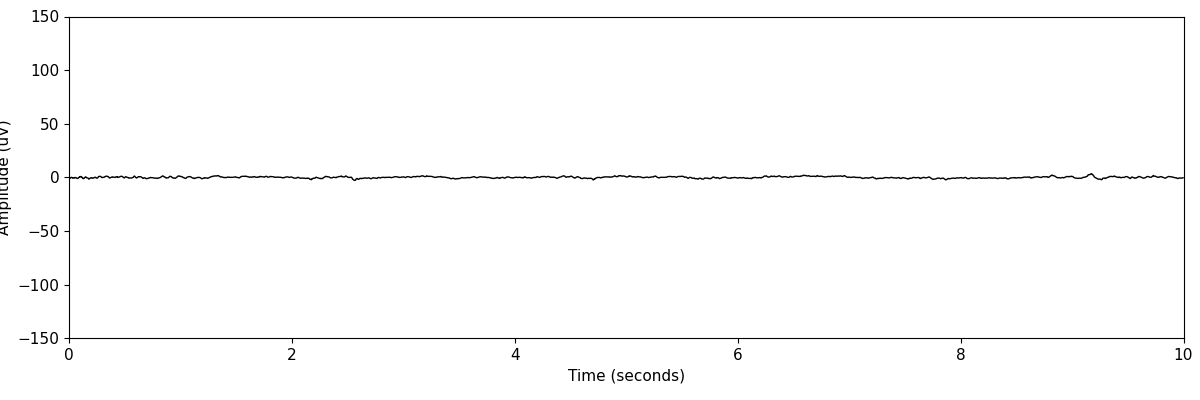

In [13]:
%matplotlib widget
sw.plot_detection()

### K-Complex Detection

In [14]:
# If not passing an MNE raw object, you will need to convert 
# values from V to uV and specify sf (sampling_freq) and ch_names
kc = sw_detect(rz_data,
               sf = sampling_freq,
               ch_names = raw.ch_names,
               hypno = hypnogram, # optionally load a hypnogram file
               include = (2, 3), # only include KC's detected in N2 and N3 sleep (if hypnogram is specified)
               freq_sw = (0.3, 4.0), # bandpass to look at events (Hz) 
               dur_neg = (0.3, 1), # min/max duration of negative deflection (seconds)
               dur_pos = (0.1, 0.5), # min/max duration of positive reflection (seconds)
               amp_neg = (5.0, None), # min/max peak amplitude of negative deflection (uV); can be (None, None)
               amp_pos = (None, None), # min/max peak amplitude of positive reflection (uV); can be (None, None)
               amp_ptp = (5.0, np.inf), # min/max peak-to-peak amplitude (uV); upper limit can be set as np.inf
               coupling = False, # irrelevant to us (see documentation)
               remove_outliers = True, # automatically remove outliers using sklearn's Isolation Forest
               verbose = False)

k_complexes = kc.summary()
k_complexes['ID'] = k_complexes.index + 1

# Print summary/plot
kc.summary(grp_stage = True)
#kc.plot_average(center = 'NegPeak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    7.1s finished
03-May-23 10:50:27 | WARNING | No SW were found in channel LOF1.
03-May-23 10:50:27 | WARNING | No SW were found in channel LOF3.
03-May-23 10:50:28 | WARNING | No SW were found in channel LOF4.
03-May-23 10:50:28 | WARNING | No SW were found in channel LOF5.
03-May-23 10:50:28 | WARNING | No SW were found in channel LOF12.
03-May-23 10:50:28 | WARNING | No SW were found in channel LAC1.
03-May-23 10:50:28 | WARNING | No SW were found in channel LAC5.
03-May-23 10:50:28 | WARNING | No SW were found in channel LAC6.
03-May-2

,Count,Density,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Stage,,,,,,,,
2,1658,27.132431,0.882294,-6.427610,2.861106,9.288717,40.588127,1.181849
3,34,17.000000,0.942444,-6.474251,2.251295,8.725547,32.663584,1.099508


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

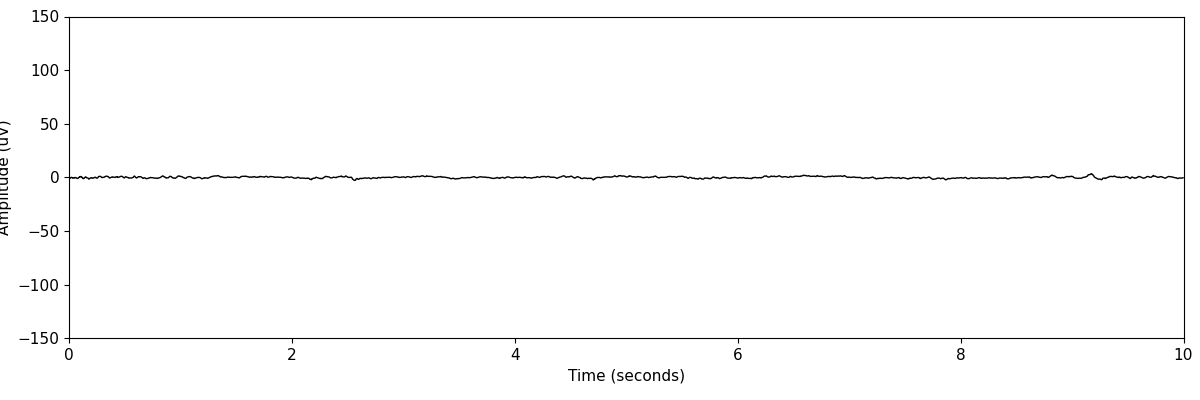

In [15]:
%matplotlib widget
kc.plot_detection()

### Spindle Detection

In [16]:
sp = spindles_detect(data,
                     sf = sampling_freq,
                     ch_names = raw.ch_names,
                     hypno = hypnogram, # optionally load a hypnogram file
                     include = (2, 3), # only include spindles detected in N2 and N3 sleep (if hyponogram is specified)
                     freq_sp = (12, 15), # bandpass to look at spindles (Hz)
                     freq_broad = (1, 30), # broadband frequency range (Hz)
                     duration = (0.5, 2), # min/max duration of spindles (seconds)
                     min_distance = 500, # merge threshold of adjacent spindles (milliseconds)
                     #thresh = {'rel_pow': ?it's a ratio?, # relative power (freq_sp / freq_broad)
                     #          'corr': ?, # moving correlation between original and sigma-filtered signals
                     #          'rms': ?}, # standard deviations above mean of moving RMS of sigma-filtered signal
                     multi_only = False, # if True, only keeps spindles present in at least two channels
                     remove_outliers = True, # detect and remove outliers using sklearn's Isolation Forest
                     )

spindles = sp.summary()
spindles['ID'] = spindles.index + 1

# Print summary/plot
sp.summary(grp_stage = True)
#sp.plot_average(center = 'Peak', time_before = 1, time_after = 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    5.3s finished
03-May-23 10:51:51 | WARNING | No spindle were found in ch

,Count,Density,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Stage,,,,,,,,,,
2,7065,115.615578,0.920886,134.616591,28.452136,2.778694,0.387606,13.412422,11.297806,0.507503
3,4,2.000000,0.699219,106.573346,23.544472,2.711182,0.304287,13.302913,9.000000,0.507919


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…

<function yasa.detection._DetectionResults.plot_detection.<locals>.update(epoch, amplitude, channel, win_size, filt)>

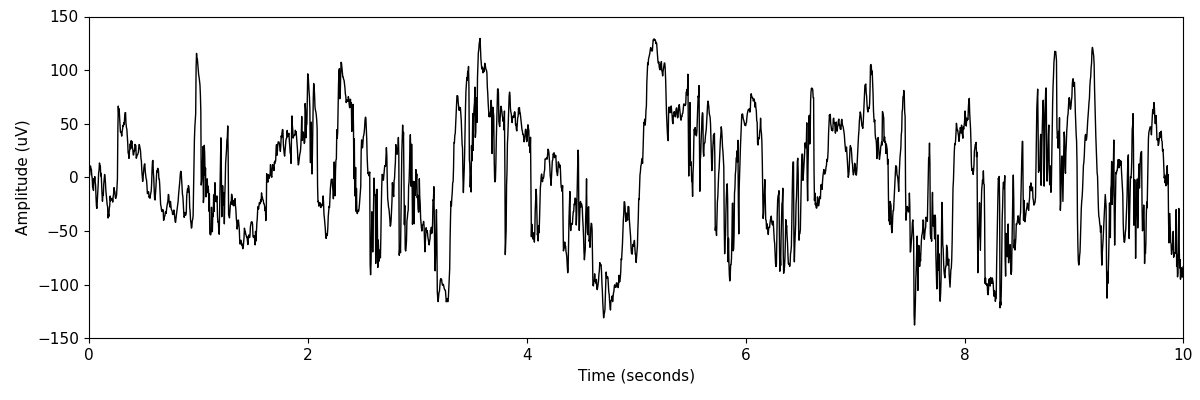

In [17]:
%matplotlib widget
sp.plot_detection()

### Summarize Events & Export

Remove channel events if the channel detected less than the event threshold.

In [18]:
# Extract event counts by channel
sw_sum = sw.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
sw_sum = sw_sum[['Channel', 'Count']]
sw_sum.columns = ['channel', 'sw']

kc_sum = kc.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
kc_sum = kc_sum[['Channel', 'Count']]
kc_sum.columns = ['channel', 'kc']

sp_sum = sp.summary(grp_chan = True, grp_stage = False, aggfunc = 'median').reset_index()
sp_sum = sp_sum[['Channel', 'Count']]
sp_sum.columns = ['channel', 'sp']

# Merge event counts and export to CSV
event_sum = pd.merge(sw_sum, kc_sum, on = ['channel'])
event_sum = pd.merge(event_sum, sp_sum, on = ['channel'])
event_sum.to_csv(event_path, index = False)

# Save sleep events to CSV
slow_waves.to_csv(sw_path, index = False)
k_complexes.to_csv(kc_path, index = False)
spindles.to_csv(sp_path, index = False)